In [1]:
from model import *
from utils import * 
from optimizer import *
from visualize import *
from meta import *
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import normalized_mutual_info_score as mis
import numpy as np

## Initialize dataset

In [2]:
latent_dim = 16

In [3]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [4]:
max_n_nodes = get_max_n_nodes(dataset)
print(f'Max number of nodes: {max_n_nodes}')

Max number of nodes: 28


In [5]:
dataset = update_dataset(dataset, max_n_nodes, latent_dim)

In [6]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Initialize & train a model

In [8]:
n_nodes = 28
feat_dim = 7
edge_dim = 4
hidden_dim = 64
latent_dim = 32
dropout = 0.0
lr = 1e-4
epochs = 1000
save_file = 'model'
model_type = 'conv'

In [9]:
if model_type == 'conv':
    model = convVAE(n_nodes, feat_dim, hidden_dim, latent_dim)
elif model_type == 'att':
    model = attVAE(n_nodes, feat_dim, hidden_dim, latent_dim)
elif model_type == 'cheb':
    model = chebVAE(n_nodes, feat_dim, hidden_dim, latent_dim)
elif model_type == 'mp':
    dims = {"e_f": edge_dim, 'n_f': feat_dim, 'u_f': latent_dim, 'hidden': hidden_dim}
    model = mpVAE(n_nodes, dims)
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
log = fit(model, optimizer, train_loader, test_loader, epochs, save_file)

Training for 1000 epochs: 100%|█████████████| 1000/1000 [01:27<00:00, 11.37it/s]

Optimization Finished!
Model type: conv
Best epoch: 933 , Best test set loss: 62.9533


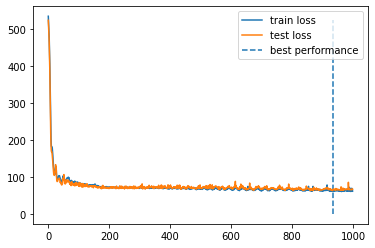

In [11]:
performance_plot(log)

## Visualize results

In [31]:
model.state_dict = torch.load('model')

In [40]:
model_mp(data.x, data.edge_index, data.edge_attr, data.u, data.batch)

(tensor([[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SigmoidBackward>),
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        grad_fn=<SqueezeBackward0>),
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        grad_fn=

In [19]:
# get random graph as Data object
data = random.choice(list(train_loader))
# the Data object is a batch => take a random index from the batch
n = random.choice(range(len(data.y)))

recovered, mu, logvar = model(data.x, data.edge_index, data.edge_attr, data.u, data.batch)
adj = data.adj
mask = create_mask(n_nodes)

In [20]:
recovered = (recovered.view(-1, n_nodes, n_nodes)*mask).detach().numpy()[n]
adj = (adj.view(-1, n_nodes, n_nodes)*mask).detach().numpy()[n]

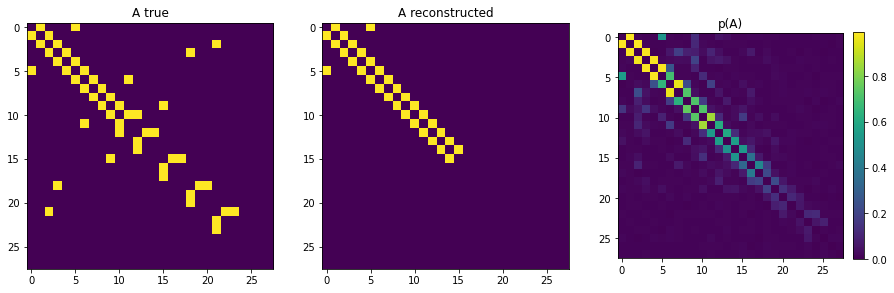

In [21]:
visualize_recon_adj(recovered, adj)

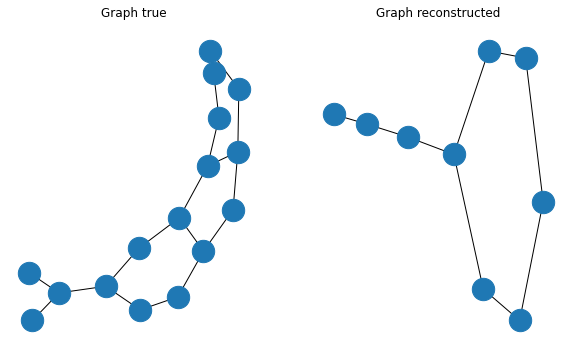

In [49]:
visualize_recon_graph(recovered, adj)

## Latent space (2D case)

In [ ]:
if model.latent_dim == 2:
    model.state_dict = torch.load('model')
    all_loader = DataLoader(dataset, batch_size=10**10, shuffle=True)
    data = next(iter(all_loader))
        
    mu, logvar = model.encode(data.x, data.edge_index, data.batch)
    z = model.reparameterize(mu, logvar).detach().numpy()
    
    visualize_z_space(z, data.y)

## Inference task I: $argmax_{A}p(A|y)$ 

In [ ]:
y = 0

In [ ]:
mask = create_mask(n_nodes)

In [ ]:
z_y = get_cluster(model, dataset, y)
z_centre = cluster_centre(z_y)

In [ ]:
if model.latent_dim == 2:
    visualize_z_space(z, data.y, z_centre.detach().numpy())

In [ ]:
a_y = model.decode(z_centre).view(model.n_nodes,model.n_nodes)
a_y = (a_y*mask).detach().numpy().squeeze()

In [ ]:
visualize_adj_graph(a_y)

## Inference task II: $argmax_{z_i \in Z} MI(z_i, Y)$ 

In [14]:
loader = DataLoader(dataset, batch_size=10**10, shuffle=True)

In [15]:
data = next(iter(loader))

In [ ]:
mu, logvar = model.encode(data.x, data.edge_index, data.batch)
z = model.reparameterize(mu, logvar).detach().numpy()

In [ ]:
cs = np.abs(cosine_similarity(z.T)).mean()
print('Average cosine similarity between latent variables: {:.2f}'.format(cs))

In [ ]:
vis_digitized(z[:,0], digitize_z(z[:,0]))

In [ ]:
# compute MI(z_i, Y) for each z_i in Z
mi = []
for i in range(hidden2):
    a = digitize_z(z[:,i])
    b = data.y.detach().numpy()
    mi.append(mis(a,b))

In [ ]:
plt.bar(x = range(len(mi)), height = mi)
plt.xlabel('$z_i$')
plt.ylabel('MI($z_i$, Y)')
plt.title('MI($z_i$, Y)')

In [ ]:
# range of z_i with max MIS
a = z[:,np.argmax(mi)].min()
b = z[:,np.argmax(mi)].max()

In [ ]:
# Vary z_i across its range and see how adajcency matrix changes
for value in np.arange(a, b, (b-a)/10):
    z = torch.zeros(hidden2)
    z[i] = value
    adj = ((model.decode(z).view(28,28)*mask).detach().numpy() > 0.5)*1
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(adj.squeeze())
    show_graphs(adj.squeeze(), ax = ax2)

In [17]:
from torch_geometric.nn import MetaLayer

In [16]:
data = next(iter(train_loader))

In [19]:
op = MetaLayer(EdgeModel(19, 10, 2), NodeModel(9, 10, 2), GlobalModel(2, 10, 2))
x, edge_attr, u = op(data.x, data.edge_index, data.edge_attr, data.u, data.batch)